In [ ]:
import os
import numpy as np
from PIL import Image

# Veri seti yolu
data_path = "/content/drive/MyDrive/malaria/cell_images/cell_images"

# Sınıf etiketleri
class_names = ["Parasitized", "Uninfected"]

# Veri setindeki görüntü sayısı
num_samples = sum([len(files) for r, d, files in os.walk(data_path)])

# Veri seti boyutları
img_height, img_width = 64, 64
num_channels =3

# X ve y için numpy dizileri
X = np.zeros((num_samples, img_height, img_width, num_channels), dtype=np.float32)
y = np.zeros((num_samples,), dtype=np.int32)

# Verileri yükleyip numpy dizilerine dönüştürme
index = 0
for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        img = img.resize((img_height, img_width))
        X[index] = np.array(img, dtype=np.float32) / 255.
        y[index] = i
        index += 1

# Veri setini karıştırma
np.random.seed(42)
shuffle_index = np.random.permutation(num_samples)
X, y = X[shuffle_index], y[shuffle_index]

# Veri setini train, test ve validation olarak ayırma
num_train_samples = int(0.7 * num_samples)
num_test_samples = int(0.2 * num_samples)
num_val_samples = num_samples - num_train_samples - num_test_samples

x_train, y_train = X[:num_train_samples], y[:num_train_samples]
x_test, y_test = X[num_train_samples:num_train_samples+num_test_samples], y[num_train_samples:num_train_samples+num_test_samples]
x_val, y_val = X[num_train_samples+num_test_samples:], y[num_train_samples+num_test_samples:]

# Dizileri npy dosyalarına kaydetme
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)
np.save('x_val.npy', x_val)
np.save('y_val.npy', y_val)


In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,roc_curve, auc
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
import seaborn as sns


In [ ]:
# Dizileri yükleme
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')

In [ ]:
# CNN Modelini Oluşturma
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, num_channels)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# CNN Modelini Eğitme
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/100
603/603 [==============================] - 21s 11ms/step - loss: 0.4557 - accuracy: 0.7785 - val_loss: 0.2360 - val_accuracy: 0.9155
Epoch 2/100
603/603 [==============================] - 4s 6ms/step - loss: 0.2096 - accuracy: 0.9244 - val_loss: 0.1744 - val_accuracy: 0.9311
Epoch 3/100
603/603 [==============================] - 4s 7ms/step - loss: 0.1647 - accuracy: 0.9441 - val_loss: 0.1699 - val_accuracy: 0.9463
Epoch 4/100
603/603 [==============================] - 5s 8ms/step - loss: 0.1469 - accuracy: 0.9521 - val_loss: 0.1562 - val_accuracy: 0.9460
Epoch 5/100
603/603 [==============================] - 4s 6ms/step - loss: 0.1236 - accuracy: 0.9573 - val_loss: 0.1686 - val_accuracy: 0.9474
Epoch 6/100
603/603 [==============================] - 4s 6ms/step - loss: 0.1012 - accuracy: 0.9656 - val_loss: 0.1611 - val_accuracy: 0.9503
Epoch 7/100
603/603 [==============================] - 4s 7ms/step - loss: 0.0795 - accuracy: 0.9715 - val_loss: 0.1971 - val_accuracy: 0.94

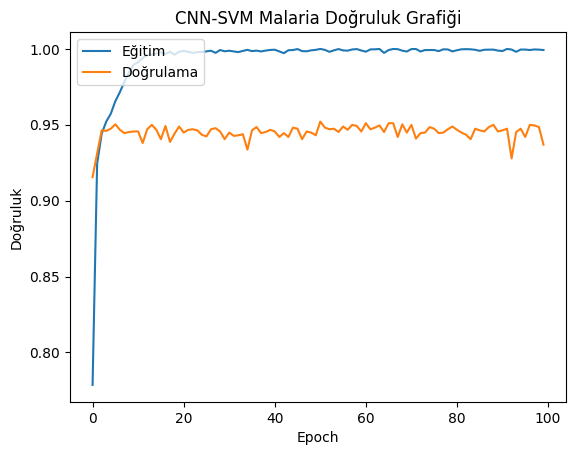

In [ ]:
# Accuracy Grafiği
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN-SVM Malaria Doğruluk Grafiği')
plt.ylabel('Doğruluk')
plt.xlabel('Epoch')
plt.legend(['Eğitim', 'Doğrulama'], loc='upper left')
plt.show()

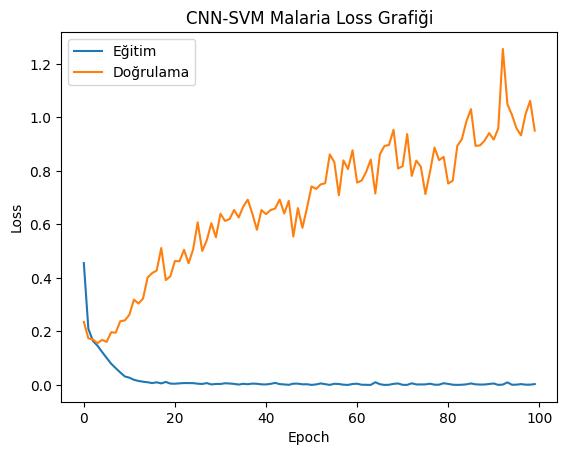

In [ ]:
# Loss Grafiği
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN-SVM Malaria Loss Grafiği')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Eğitim', 'Doğrulama'], loc='upper left')
plt.show()

In [ ]:
# CNN modelinden özellik çıkarma
train_features = cnn_model.predict(x_train)
test_features = cnn_model.predict(x_test)

173/173 [==============================] - 0s 2ms/step


In [ ]:
# SVM Modelini Oluşturma ve eğitme
svm_model = SVC()
svm_model.fit(train_features, y_train)


SVC()

In [ ]:
# SVM ile tahmin yapma
svm_predictions = svm_model.predict(test_features)

In [ ]:
# Hibrit modelin performansını değerlendirme
train_predictions = svm_model.predict(train_features)
test_predictions = svm_model.predict(test_features)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print("Eğitim verisi doğruluğu:", train_accuracy)
print("Test verisi doğruluğu:", test_accuracy)


Eğitim verisi doğruluğu: 0.9997407983411094
Test verisi doğruluğu: 0.9401197604790419


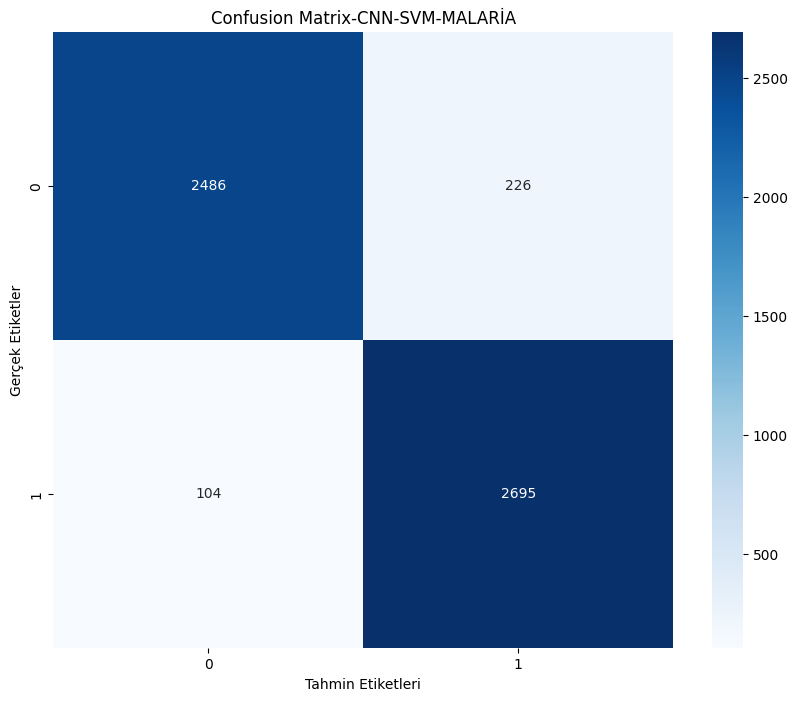

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix-CNN-SVM-MALARİA')
plt.xlabel('Tahmin Etiketleri')
plt.ylabel('Gerçek Etiketler')
plt.show()

In [ ]:
# Sınıflandırma raporu
classification_rep = classification_report(y_test, svm_predictions)
print('Sınıflandırma Raporu:\n', classification_rep)

# Recall, Precision ve F1-Score değerlerini elde etme
report_lines = classification_rep.split('\n')
for line in report_lines[2:-5]:
    line_data = line.split()
    if len(line_data) >= 4:
        class_label = int(line_data[0])
        precision = float(line_data[1])
        recall = float(line_data[2])
        f1 = float(line_data[3])
        print('Sınıf:', class_label)
        print('Precision:', precision)
        print('Recall:', recall)
        print('F1-score:', f1)
        print('----------------------')

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      2712
           1       0.92      0.96      0.94      2799

    accuracy                           0.94      5511
   macro avg       0.94      0.94      0.94      5511
weighted avg       0.94      0.94      0.94      5511

Sınıf: 0
Precision: 0.96
Recall: 0.92
F1-score: 0.94
----------------------
Sınıf: 1
Precision: 0.92
Recall: 0.96
F1-score: 0.94
----------------------


Mikro-Ortalama AUC Skoru: 0.9397552697391924
Makro-Ortalama AUC Skoru: 0.9397552697391924


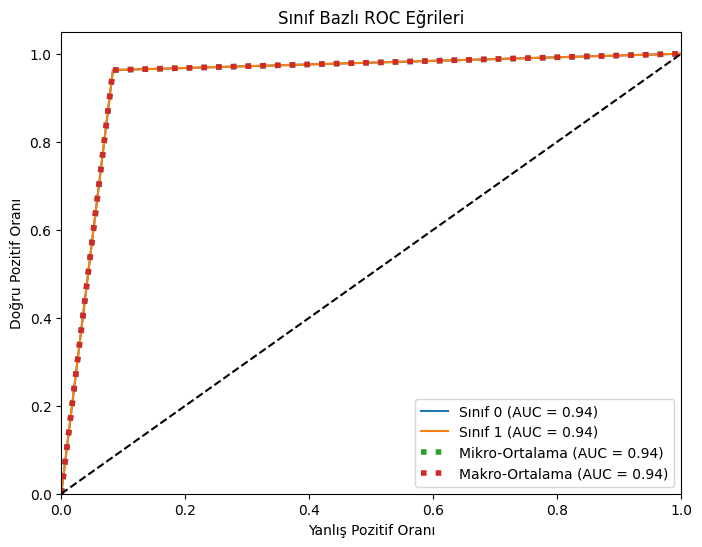

In [ ]:
# ROC eğrisi ve AUC skoru hesaplama
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, svm_predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Mikro-ortalamalı ROC eğrisi ve AUC skoru hesaplama
fpr_micro, tpr_micro, _ = roc_curve(y_test, svm_predictions)
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Makro-ortalamalı ROC eğrisi ve AUC skoru hesaplama
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 2
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Sonuçları yazdırma
print('Mikro-Ortalama AUC Skoru:', roc_auc_micro)
print('Makro-Ortalama AUC Skoru:', roc_auc_macro)

# ROC eğrilerini çizme
plt.figure(figsize=(8, 6))
for i in range(2):  # Sınıf sayısı 2 olduğunu varsayalım
    plt.plot(fpr[i], tpr[i], label='Sınıf %d (AUC = %0.2f)' % (i, roc_auc[i]))

# Mikro-ortalamalı ROC eğrisini çizme
plt.plot(fpr_micro, tpr_micro, label='Mikro-Ortalama (AUC = %0.2f)' % roc_auc_micro, linestyle=':', linewidth=4)

# Makro-ortalamalı ROC eğrisini çizme
plt.plot(fpr_macro, tpr_macro, label='Makro-Ortalama (AUC = %0.2f)' % roc_auc_macro, linestyle=':', linewidth=4)

# Rastgele tahmin edilen ROC eğrisini çizme
plt.plot([0, 1], [0, 1], 'k--')

# Eksen ve başlık ayarları
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı')
plt.ylabel('Doğru Pozitif Oranı')
plt.title('Sınıf Bazlı ROC Eğrileri')
plt.legend(loc="lower right")

# Grafik gösterme
plt.show()
